In [59]:
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from collections import Counter
import pandas as pd
import math
from ucimlrepo import fetch_ucirepo 
  



In [60]:
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 


In [61]:
# data (as pandas dataframes) 
features = statlog_german_credit_data.data.features 
targets = statlog_german_credit_data.data.targets 

dataset = pd.concat([features, targets], axis=1)


In [62]:
dataset = dataset.sample(frac=1)
dataset

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20,class
868,A14,36,A32,A49,7409,A65,A75,3,A93,A101,...,A122,37,A143,A152,2,A173,1,A191,A201,1
95,A12,54,A30,A49,15945,A61,A72,3,A93,A101,...,A124,58,A143,A151,1,A173,1,A192,A201,2
58,A13,18,A32,A40,1961,A61,A75,3,A92,A101,...,A123,23,A143,A152,1,A174,1,A191,A201,1
77,A12,11,A33,A43,4771,A61,A74,2,A93,A101,...,A122,51,A143,A152,1,A173,1,A191,A201,1
264,A14,10,A34,A40,1231,A61,A75,3,A93,A101,...,A121,32,A143,A152,2,A172,2,A191,A202,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,A14,18,A33,A42,1808,A61,A74,4,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
932,A14,9,A34,A40,1224,A61,A73,3,A93,A101,...,A121,30,A143,A152,2,A173,1,A191,A201,1
254,A12,9,A32,A42,2030,A65,A74,2,A93,A101,...,A123,24,A143,A152,1,A173,1,A192,A201,1
51,A12,27,A33,A41,5965,A61,A75,1,A93,A101,...,A123,30,A143,A152,2,A174,1,A192,A201,1


In [64]:
print(dataset.columns)
# dataset = dataset.drop(['Protime', 'Spiders'], axis=1)
features = dataset.drop('class', axis=1).values
labels = dataset['class'].values
features

Index(['Attribute1', 'Attribute2', 'Attribute3', 'Attribute4', 'Attribute5',
       'Attribute6', 'Attribute7', 'Attribute8', 'Attribute9', 'Attribute10',
       'Attribute11', 'Attribute12', 'Attribute13', 'Attribute14',
       'Attribute15', 'Attribute16', 'Attribute17', 'Attribute18',
       'Attribute19', 'Attribute20', 'class'],
      dtype='object')


array([['A14', 36, 'A32', ..., 1, 'A191', 'A201'],
       ['A12', 54, 'A30', ..., 1, 'A192', 'A201'],
       ['A13', 18, 'A32', ..., 1, 'A191', 'A201'],
       ...,
       ['A12', 9, 'A32', ..., 1, 'A192', 'A201'],
       ['A12', 27, 'A33', ..., 1, 'A192', 'A201'],
       ['A11', 24, 'A31', ..., 1, 'A192', 'A201']], dtype=object)

In [65]:
def normalize(train, test, epsilon=1e-10):
    min_val = np.min(train, axis=0)
    max_val = np.max(train, axis=0)
    train_norm = (train - min_val) / (max_val - min_val + epsilon)
    test_norm = (test - min_val) / (max_val - min_val + epsilon)
    return train_norm, test_norm

In [66]:
numerical_indices = [1,4,7,10,12,15,17]
categorical_indices = [0,2,3,5,6,8,9,11,13,14,16,18,19]
X_numerical = np.array(features[:, numerical_indices], dtype=float)
X_categorical = features[:, categorical_indices]
feature_encoder = OneHotEncoder(sparse=False)
X_categorical_encoded = feature_encoder.fit_transform(X_categorical)
X_numerical_normalized, _ = normalize(X_numerical, X_numerical)
X = np.hstack((X_numerical_normalized, X_categorical_encoded))
label_encoder = OneHotEncoder(sparse=False)
y = label_encoder.fit_transform(labels.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/Users/ananyashekhawat/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/ananyashekhawat/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [67]:
def stratified_cross_validation(features, labels, k=10):
    label_indices = [np.where(labels == label)[0] for label in np.unique(labels)]
    folds = []
    pairs = []
    shuffled_label_indices = [np.random.permutation(label_list) for label_list in label_indices]
    label_splits = [np.array_split(label_list, k) for label_list in shuffled_label_indices]
    for fold_parts in zip(*label_splits):
        fold = np.concatenate(fold_parts)
        folds.append(fold)
    for fold_index in range(k):
        test_fold = folds[fold_index]
        train_fold = np.concatenate([folds[i] for i in range(k) if i != fold_index])
        pairs.append((train_fold, test_fold))
    return pairs

Question 1. Evaluate the performance of at least two algorithms you studied and/or implemented during the semester (e.g., k-NN, Decision Trees, standard Naive Bayes, Random Forests, Neural Networks, etc).1 You should discuss which algorithms you decided to test on each dataset and why.

# Neural Network Algorithm

Please note that we used Cyril's implementation of NN here.

In [68]:
class NN:
    def __init__(self, sizes, initial_weights=None, eta=0.01, reg_lambda=0.01, use_softmax=False):
        self.sizes = sizes
        self.eta = eta
        self.reg_lambda = reg_lambda
        self.use_softmax = use_softmax
        self.weights = self.init_weights() if initial_weights is None else initial_weights

    def init_weights(self):
        return [np.random.randn(y, x + 1) * 0.1 for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def add_bias(self, X):
        return np.insert(X, 0, 1, axis=1)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        act = [self.add_bias(X)]
        ll = []
        for index, weight in enumerate(self.weights[:-1]):
            ll.append(act[-1] @ weight.T)
            act.append(self.add_bias(1 / (1 + np.exp(-ll[-1]))))
        ll.append(act[-1] @ self.weights[-1].T)
        act.append(self.softmax(ll[-1]) if self.use_softmax else 1 / (1 + np.exp(-ll[-1])))
        return act, ll

    def cost(self, Y, act):
        xq = Y.shape[0]
        return -np.sum(Y * np.log(act[-1] + 1e-8)) / xq if self.use_softmax else -np.sum(Y * np.log(act[-1]) + (1 - Y) * np.log(1 - act[-1])) / xq

    def backward(self, targets, activations, weights):
        num_samples = targets.shape[0]
        errors = [activations[-1] - targets]
        gradients = []
        for i in range(len(weights) - 1, 0, -1):
            delta = (errors[0] @ weights[i][:, 1:]) * activations[i][:, 1:] * (1 - activations[i][:, 1:])
            errors.insert(0, delta)
        for i in range(len(weights)):
            grad = errors[i].T @ activations[i] / num_samples
            gradients.append(grad)
        return errors, gradients

    def update_weights(self, gradients):
        for i in range(len(self.weights)):
            regularization_grad = (self.reg_lambda * self.weights[i]) / self.weights[i].shape[0]
            regularization_grad[:, 0] = 0
            self.weights[i] -= self.eta * (gradients[i] + regularization_grad)

    def predict(self, inputs):
        final_activations, _ = self.forward(inputs)
        return np.argmax(final_activations[-1], axis=1) + 1

    def train(self, inputs, labels, iterations):
        for _ in range(iterations):
            final_activations, _ = self.forward(inputs)
            _, weight_gradients = self.backward(labels, final_activations, self.weights)
            self.update_weights(weight_gradients)
        return self.weights


In [69]:
def accuracy(Y, predictions):
    true_labels = np.argmax(Y, axis=1) + 1
    accuracy = np.mean(predictions == true_labels)
    return accuracy * 100

def f1_score(Y, predictions):
    true_labels = np.argmax(Y, axis=1) + 1
    classes = np.unique(true_labels)
    f1_scores = []
    for c in classes:
        tp = np.sum((predictions == c) & (true_labels == c))
        fp = np.sum((predictions == c) & (true_labels != c))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        fn = np.sum((predictions != c) & (true_labels == c))
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
    avg_f1 = np.mean(f1_scores) * 100
    return avg_f1

In [71]:
print(X.shape[1])
nn = NN([X.shape[1], 30, 2], eta=0.05, reg_lambda=0.01, use_softmax=True)
trained_weights = nn.train(X_train, y_train, iterations=20000)
train_predictions = nn.predict(X_train)
train_accuracy = accuracy(y_train, train_predictions)
train_f1score = f1_score(y_train, train_predictions)
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Training F1 Score: {train_f1score:.2f}%")
test_predictions = nn.predict(X_test)
test_accuracy = accuracy(y_test, test_predictions)
test_f1score = f1_score(y_test, test_predictions)
print(f"Testing Accuracy: {test_accuracy:.2f}%")
print(f"Testing F1 Score: {test_f1score:.2f}%")

61
Training Accuracy: 79.25%
Training F1 Score: 73.76%
Testing Accuracy: 78.50%
Testing F1 Score: 71.52%


In [72]:
def test_hyperparameters(features, labels, k=10):
    eta_values = [0.05, 0.1, 0.2]
    reg_lambda_values = [0.01, 0.05, 0.1]
    layer_configurations = [
        [X.shape[1], 10, 2] ,
        [X.shape[1], 20, 2] ,
        [X.shape[1], 10, 10, 2],
        [X.shape[1], 20, 20, 2]
    ]
    results = []
    for eta in eta_values:
        for reg_lambda in reg_lambda_values:
            for layers in layer_configurations:
                train_accuracies = []
                train_f1_scores = []
                test_accuracies = []
                test_f1_scores = []
                splits = stratified_cross_validation(features, labels, k)
                for train_indices, test_indices in splits:
                    X_train, y_train = features[train_indices], labels[train_indices]
                    X_test, y_test = features[test_indices], labels[test_indices]
                    nn = NN(layers, eta=eta, reg_lambda=reg_lambda, use_softmax=True)
                    nn.train(X_train, y_train, iterations=1000)
                    train_predictions = nn.predict(X_train)
                    train_accuracy = accuracy(y_train, train_predictions)
                    train_f1 = f1_score(y_train, train_predictions)
                    test_predictions = nn.predict(X_test)
                    test_accuracy = accuracy(y_test, test_predictions)
                    test_f1 = f1_score(y_test, test_predictions)
                    train_accuracies.append(train_accuracy)
                    train_f1_scores.append(train_f1)
                    test_accuracies.append(test_accuracy)
                    test_f1_scores.append(test_f1)
                results.append({
                    "configuration": layers,
                    "lambda": reg_lambda,
                    "learning_rate": eta,
                    "train_accuracy": np.mean(train_accuracies),
                    "train_f1": np.mean(train_f1_scores),
                    "test_accuracy": np.mean(test_accuracies),
                    "test_f1": np.mean(test_f1_scores)
                })
    return results


In [73]:
results_nn = test_hyperparameters(X, y, k=10)
for result in results_nn:
    print(f"Structure: {result['configuration']}, Lambda: {result['lambda']}, Learning Rate: {result['learning_rate']}, "
          f"Train Acc: {result['train_accuracy']:.2f}, Train F1: {result['train_f1']:.2f}, Test Acc: {result['test_accuracy']:.2f}, "
          f"Test F1: {result['test_f1']:.2f}")

Structure: [61, 10, 2], Lambda: 0.01, Learning Rate: 0.05, Train Acc: 70.28, Train F1: 42.74, Test Acc: 70.10, Test F1: 42.02
Structure: [61, 20, 2], Lambda: 0.01, Learning Rate: 0.05, Train Acc: 72.82, Train F1: 53.70, Test Acc: 71.70, Test F1: 51.57
Structure: [61, 10, 10, 2], Lambda: 0.01, Learning Rate: 0.05, Train Acc: 70.00, Train F1: 41.18, Test Acc: 70.00, Test F1: 41.17
Structure: [61, 20, 20, 2], Lambda: 0.01, Learning Rate: 0.05, Train Acc: 70.00, Train F1: 41.18, Test Acc: 70.00, Test F1: 41.17
Structure: [61, 10, 2], Lambda: 0.05, Learning Rate: 0.05, Train Acc: 70.00, Train F1: 41.18, Test Acc: 70.00, Test F1: 41.15
Structure: [61, 20, 2], Lambda: 0.05, Learning Rate: 0.05, Train Acc: 70.03, Train F1: 41.33, Test Acc: 69.95, Test F1: 41.15
Structure: [61, 10, 10, 2], Lambda: 0.05, Learning Rate: 0.05, Train Acc: 70.00, Train F1: 41.18, Test Acc: 70.00, Test F1: 41.16
Structure: [61, 20, 20, 2], Lambda: 0.05, Learning Rate: 0.05, Train Acc: 70.00, Train F1: 41.18, Test Acc

In [ ]:
def display_sorted_results(results):
    df = pd.DataFrame(results)
    sort_columns = ['test_accuracy', 'test_f1']
    sorted_df = df.sort_values(by=sort_columns, ascending=[False, False])
    print(sorted_df.to_string(index=False))

display_sorted_results(results_nn)

  configuration  lambda  learning_rate  train_accuracy  train_f1  test_accuracy   test_f1
    [20, 10, 2]    0.01           0.20       80.949074 72.912554      81.041667 73.061115
    [20, 30, 2]    0.01           0.20       80.995370 72.997500      81.041667 72.994892
    [20, 30, 2]    0.01           0.10       80.833333 72.696064      80.833333 72.453375
    [20, 30, 2]    0.05           0.20       80.613426 72.281838      80.520833 71.769905
    [20, 10, 2]    0.01           0.10       79.791667 70.532833      79.583333 70.249983
    [20, 10, 2]    0.05           0.20       79.467593 69.945407      79.583333 69.801533
    [20, 30, 2]    0.10           0.20       78.402778 67.241465      78.125000 66.904504
    [20, 30, 2]    0.05           0.10       78.171296 66.694131      77.916667 65.863878
    [20, 30, 2]    0.01           0.05       72.789352 52.260616      71.979167 50.449981
    [20, 10, 2]    0.05           0.10       70.162037 44.343218      70.208333 43.878230
[20, 30, 3

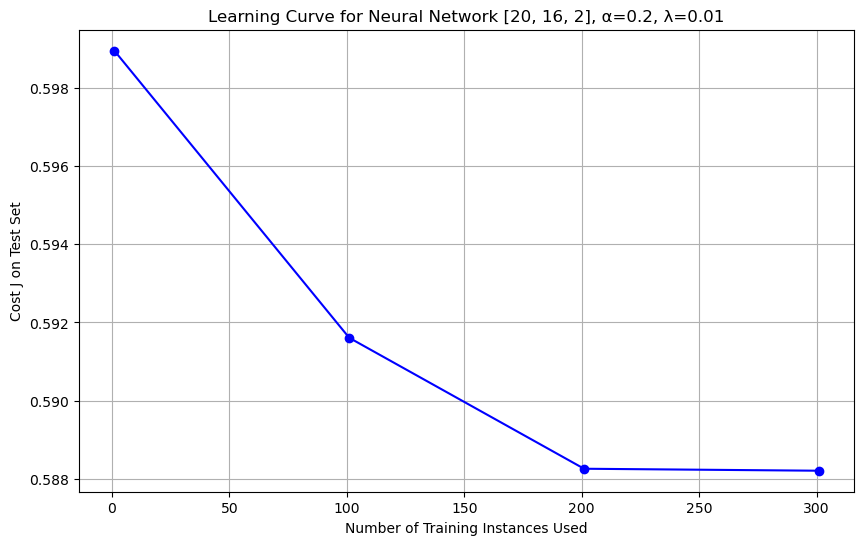

In [ ]:
def learning_curve(X_train, y_train, X_test, y_test, nn, increments=100):
    costs = []
    for i in range(1, len(X_train), increments):
        nn.train(X_train[:i], y_train[:i], iterations=1)
        activations, _ = nn.forward(X_test)
        cost = nn.cost(y_test, activations[-1])
        costs.append(cost)
    return costs

np.random.seed(0)
nn = NN([20, 10, 2], eta=0.2, reg_lambda=0.01, use_softmax=True)
costs = learning_curve(X_train, y_train, X_test, y_test, nn)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X_train), 100), costs, marker='o', linestyle='-', color='b')
plt.title('Learning Curve for Neural Network [20, 10, 2], α=0.2, λ=0.01')
plt.xlabel('Number of Training Instances Used')
plt.ylabel('Cost J on Test Set')
plt.grid(True)

# Random Forests

Please note that we used Cyril's implementation of Random Forests here.

In [82]:
def feature_type(dataset):
    feature_types = {}
    feature_descriptions = {
        "Attribute1": "categorical",
        "Attribute2":"numerical",
        "Attribute3":"categorical",
        "Attribute4":"categorical",
        "Attribute5":"numerical",
        "Attribute6":"categorical",
        "Attribute7":"categorical",
        "Attribute8":"numerical",
        "Attribute9":"categorical",
        "Attribute10":"categorical",
        "Attribute11":"numerical",
        "Attribute12":"categorical",
        "Attribute13":"numerical",
        "Attribute14":"categorical",
        "Attribute15":"categorical",
        "Attribute16":"numerical",
        "Attribute17":"categorical",
        "Attribute18":"numerical",
        "Attribute19":"categorical",
        "Attribute20":"categorical",
    }
    for column in dataset.columns:
        if column == 'class':
          continue
        if column in feature_descriptions:
            feature_types[column] = feature_descriptions[column]
        else:
            raise ValueError(f"{column} does not exist")
    return feature_types

feature_types = feature_type(dataset)
print(feature_types)


{'Attribute1': 'categorical', 'Attribute2': 'numerical', 'Attribute3': 'categorical', 'Attribute4': 'categorical', 'Attribute5': 'numerical', 'Attribute6': 'categorical', 'Attribute7': 'categorical', 'Attribute8': 'numerical', 'Attribute9': 'categorical', 'Attribute10': 'categorical', 'Attribute11': 'numerical', 'Attribute12': 'categorical', 'Attribute13': 'numerical', 'Attribute14': 'categorical', 'Attribute15': 'categorical', 'Attribute16': 'numerical', 'Attribute17': 'categorical', 'Attribute18': 'numerical', 'Attribute19': 'categorical', 'Attribute20': 'categorical'}


In [77]:
class DT:
    def __init__(self, max_depth=20, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def entropy(self, labels):
        label, counts = np.unique(labels, return_counts=True)
        prob = counts / counts.sum()
        return -np.sum(prob * np.log2(prob))

    def information_gain_numerical(self, labels, true_labels, false_labels):
        prob = float(len(true_labels)) / len(labels)
        info_gain = self.entropy(labels) - prob * self.entropy(true_labels) - (1 - prob) * self.entropy(false_labels)
        return info_gain

    def information_gain_categorical(self, labels, partitions):
        values, counts = np.unique(partitions, return_counts=True)
        avg_entropy_of_partitions = sum((counts[i] / sum(counts)) * self.entropy(labels[partitions == value]) for i, value in enumerate(values))
        return self.entropy(labels) - avg_entropy_of_partitions

    def best_split(self, features, labels, feature_types, min_info_gain=0.01):
        best_gain = -np.inf
        best_feature = None
        best_split_val = None
        m = int(math.sqrt(len(features.columns)))
        m_features = np.random.choice(features.columns, m, replace=False)
        for feature in m_features:
            # print("m_features",m_features)
            # print("feature",feature)
            # print("feature_types",feature_types)
            if feature_types[feature] == "categorical":
                info_gain = self.information_gain_categorical(labels, features[feature])
                if info_gain > best_gain and info_gain >= min_info_gain:
                    best_gain, best_feature = info_gain, feature
                    best_split_val = None
            else:
                sorted_indices = features[feature].sort_values().index
                sorted_labels = labels.loc[sorted_indices]
                sorted_features = features.loc[sorted_indices, feature]
                for i in range(1, len(sorted_features)):
                    if sorted_features.iloc[i] == sorted_features.iloc[i - 1]:
                        continue
                    split_val = (sorted_features.iloc[i] + sorted_features.iloc[i - 1]) / 2
                    true_labels = sorted_labels[sorted_features <= split_val]
                    false_labels = sorted_labels[sorted_features > split_val]
                    info_gain = self.information_gain_numerical(labels, true_labels, false_labels)
                    if info_gain > best_gain and info_gain >= min_info_gain:
                        best_gain, best_feature, best_split_val = info_gain, feature, split_val
        return best_feature, best_split_val

    def build_dt(self, features, labels, feature_types, depth=0):
        if len(np.unique(labels)) == 1 or len(features) < self.min_samples_leaf or (self.max_depth and depth >= self.max_depth):
            return np.unique(labels)[0]
        else:
            best_feature, best_split_val = self.best_split(features, labels, feature_types)
            if best_feature is None:
                return np.unique(labels)[np.argmax(np.unique(labels, return_counts=True)[1])]
            tree = {best_feature: {}}
            if best_split_val is None:
                for value in np.unique(features[best_feature]):
                    subtree_features = features[features[best_feature] == value].drop(columns=[best_feature])
                    subtree_labels = labels[features[best_feature] == value]
                    subtree = self.build_dt(subtree_features, subtree_labels, feature_types, depth + 1)
                    tree[best_feature][value] = subtree
            else:
                left_indices = features[best_feature] <= best_split_val
                right_indices = features[best_feature] > best_split_val
                left_subtree = self.build_dt(features[left_indices], labels[left_indices], feature_types, depth + 1)
                right_subtree = self.build_dt(features[right_indices], labels[right_indices], feature_types, depth + 1)
                tree[best_feature] = {"<= {:.2f}".format(best_split_val): left_subtree , "> {:.2f}".format(best_split_val): right_subtree}
            return tree

    def fit(self, features, labels, feature_types):
        self.feature_types = feature_types
        self.tree = self.build_dt(features, labels, feature_types)

    def predict(self, dataset):
        predictions = []
        for _, instance in dataset.iterrows():
            prediction = self.predict_helper(instance, self.tree)
            predictions.append(prediction)
        return np.array(predictions)

    def predict_helper(self, instance, tree):
        if not isinstance(tree, dict):
            return tree
        feature = next(iter(tree))
        if self.feature_types[feature] == 'categorical':
            if instance[feature] in tree[feature]:
                return self.predict_helper(instance, tree[feature][instance[feature]])
        else:
            for key, subtree in tree[feature].items():
                if key.startswith('<='):
                    split_val = float(key.split('<= ')[1])
                    if instance[feature] <= split_val:
                        return self.predict_helper(instance, subtree)
                elif key.startswith('>'):
                    split_val = float(key.split('> ')[1])
                    if instance[feature] > split_val:
                        return self.predict_helper(instance, subtree)
                else:
                    if instance[feature] == key:
                        return self.predict_helper(instance, subtree)
        return np.nan


In [78]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=20, min_samples_leaf=1):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.trees = []

    def bootstrap(self, features, labels):
        num_samples = features.shape[0]
        indices = np.random.choice(num_samples, num_samples, replace=True)
        return features.iloc[indices], labels.iloc[indices]

    def fit(self, features, labels, feature_types):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DT(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            features_sample, labels_sample = self.bootstrap(features, labels)
            tree.fit(features_sample, labels_sample, feature_types)
            self.trees.append(tree)

    def predict(self, instances):
        tree_preds = [tree.predict(instances) for tree in self.trees]
        tree_preds = np.array(tree_preds).T
        majority_votes = [self.most_common_label(pred) for pred in tree_preds]
        return np.array(majority_votes)

    def most_common_label(self, pred):
        return Counter(pred).most_common(1)[0][0]

In [79]:
def unique_labels_filter(true_labels):
    filtered_labels = [label for label in true_labels if not np.isnan(label)]
    return np.unique(filtered_labels)

def mc_cm(true_labels, predictions, num_classes):
    unique_labels = unique_labels_filter(true_labels)
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    confusion_matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]
    for true, pred in zip(true_labels, predictions):
        if np.isnan(pred):
            continue
        true_idx = label_to_index[true]
        pred_idx = label_to_index.get(pred, -1)
        if pred_idx != -1:
            confusion_matrix[true_idx][pred_idx] += 1
    return confusion_matrix

def metrics_calc(confusion_matrix):
    metrics = {'precision': [], 'recall': [], 'f1': []}
    for i in range(len(confusion_matrix)):
        TP = confusion_matrix[i][i]
        FN = sum(confusion_matrix[i][j] for j in range(len(confusion_matrix)) if j != i)
        FP = sum(confusion_matrix[j][i] for j in range(len(confusion_matrix)) if j != i)
        TN = sum(sum(confusion_matrix[j][k] for k in range(len(confusion_matrix)) if k != i) for j in range(len(confusion_matrix)) if j != i)
        precision = TP / (TP + FP) if TP + FP > 0 else 0
        recall = TP / (TP + FN) if TP + FN > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        metrics['f1'].append(f1)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
    for metric in metrics:
        metrics[metric] = sum(metrics[metric]) / len(metrics[metric])
    return metrics


In [80]:
def evaluate_rf(features, labels, feature_types, k=10, ntree=1):
    scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    pairs = stratified_cross_validation(features, labels, k=k)
    num_classes = len(np.unique(labels))
    for train_indices, test_indices in pairs:
        features_train, labels_train = features.iloc[train_indices], labels.iloc[train_indices]
        features_test, labels_test = features.iloc[test_indices], labels.iloc[test_indices]
        ensemble = RandomForest(n_trees=ntree, max_depth=10, min_samples_leaf=1)
        ensemble.fit(features_train, labels_train, feature_types)
        predictions = ensemble.predict(features_test)
        confusion_matrix = mc_cm(labels_test.to_numpy(), predictions, num_classes)
        metrics = metrics_calc(confusion_matrix)
        accuracy = sum(confusion_matrix[i][i] for i in range(num_classes)) / sum(sum(row) for row in confusion_matrix)
        scores['accuracy'].append(accuracy)
        scores['precision'].append(metrics['precision'])
        scores['recall'].append(metrics['recall'])
        scores['f1'].append(metrics['f1'])
    avg_perf = {metric: np.mean(values) for metric, values in scores.items()}
    return avg_perf

In [84]:
features_df = pd.DataFrame(features, columns=[
        "Attribute1", 
        "Attribute2",
        "Attribute3",
        "Attribute4",
        "Attribute5",
        "Attribute6",
        "Attribute7",
        "Attribute8", 
        "Attribute9",
        "Attribute10",
        "Attribute11",
        "Attribute12",
        "Attribute13",
        "Attribute14",
        "Attribute15", 
        "Attribute16",
        "Attribute17",
        "Attribute18",
        "Attribute19",
        "Attribute20",
        ])
labels_df = pd.Series(labels)
average_performance_rf1 = evaluate_rf(features_df, labels_df, feature_types, k=10, ntree=1)
print(f"Metrics for a value of ntree = {1}: {average_performance_rf1}")

Metrics for a value of ntree = 1: {'accuracy': 0.6525581459143828, 'precision': 0.5788762840820372, 'recall': 0.568957213024834, 'f1': 0.5692681784783007}


In [85]:
ntree_values = [1, 5, 10, 20, 30, 40, 50]
metrics_results = {'ntree': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
for ntree in ntree_values:
    average_performance = evaluate_rf(features_df, labels_df, feature_types, k=10, ntree=ntree)
    metrics_results['ntree'].append(ntree)
    metrics_results['accuracy'].append(average_performance['accuracy'])
    metrics_results['precision'].append(average_performance['precision'])
    metrics_results['recall'].append(average_performance['recall'])
    metrics_results['f1'].append(average_performance['f1'])
    print(f"Metrics for a value of ntree = {ntree}: {average_performance}")


Metrics for a value of ntree = 1: {'accuracy': 0.6799881650524886, 'precision': 0.6199413788322237, 'recall': 0.6133536522041142, 'f1': 0.6125016627260947}


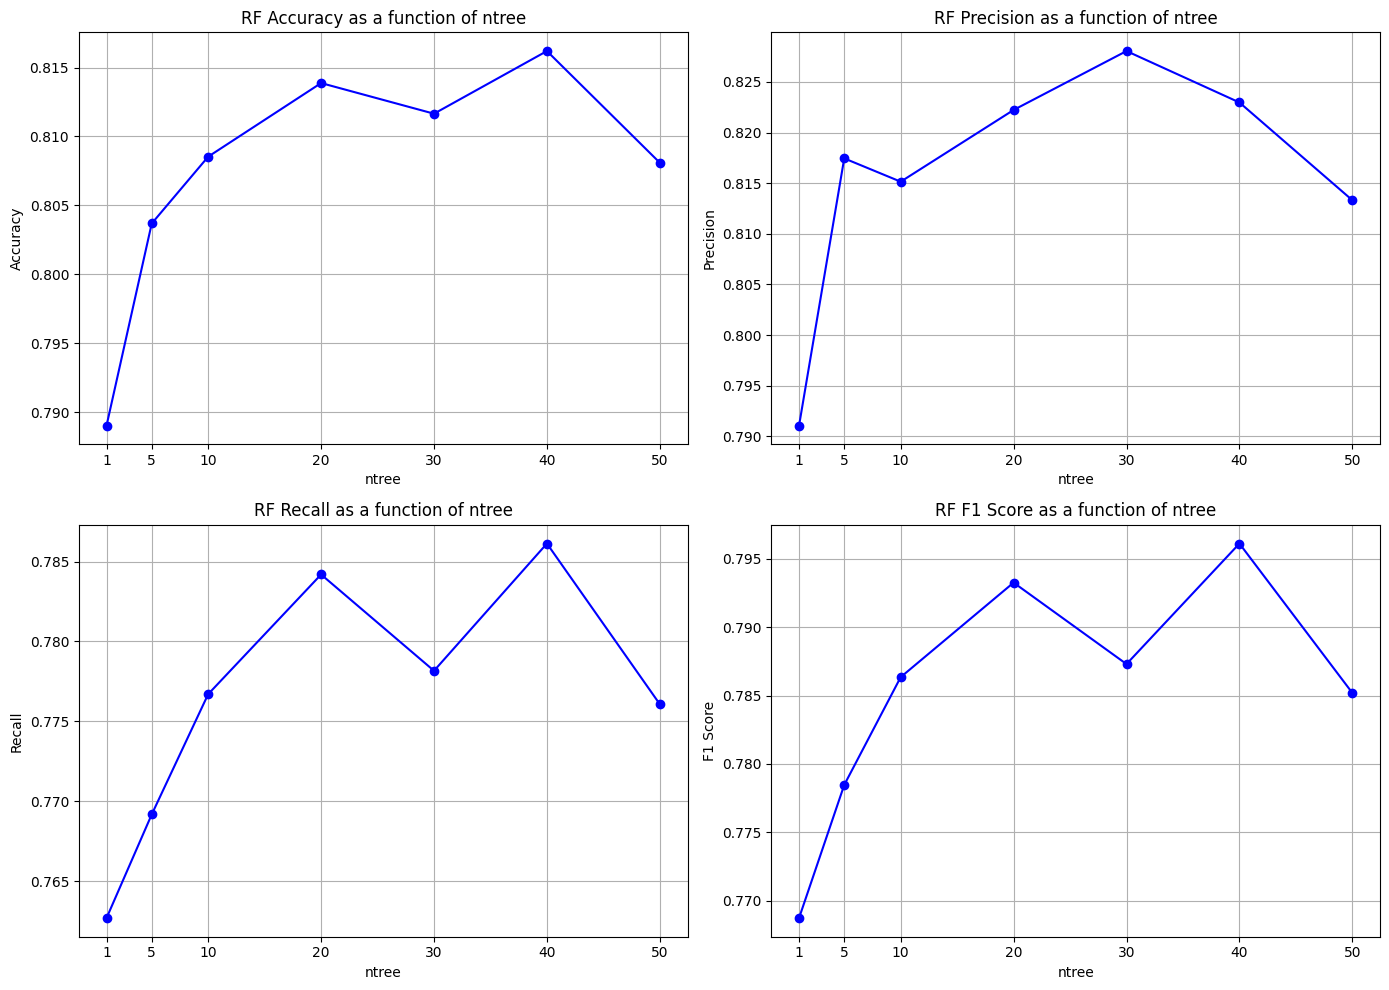

In [ ]:
def plot(metrics):
    plt.figure(figsize=(14, 10))
    titles = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1'], start=1):
        plt.subplot(2, 2, i)
        plt.plot(metrics['ntree'], metrics[metric], marker='o', linestyle='-', color='b')
        plt.title(f'RF {titles[i-1]} as a function of ntree')
        plt.xlabel('ntree')
        plt.ylabel(titles[i-1])
        plt.xticks(metrics_results['ntree'])
        plt.grid(True)
    plt.tight_layout()
    plt.show()
plot(metrics_results)